In [1]:
import numpy as np
import matplotlib.pyplot as plt

def create_bell_state():
    """Generate a Bell state |Φ+⟩ = (|00⟩ + |11⟩) / sqrt(2)."""
    return np.array([1, 0, 0, 1]) / np.sqrt(2)

def hadamard_transform(state):
    """Apply the Hadamard transform to a quantum state."""
    H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])
    return np.kron(H, H).dot(state)


def apply_noise(state, snr_db, loss_db):
    """
    Apply noise based on SNR in dB and simulate loss in dB.
    
    :param state: Quantum state represented as a numpy array.
    :param snr_db: Signal-to-Noise Ratio in decibels.
    :param loss_db: Loss in decibels.
    :return: Quantum state after noise and loss have been applied.
    """
    # Convert loss from dB to a linear scale factor
    loss_factor = 10 ** (-loss_db / 10)

    # Apply loss to the quantum state
    state_after_loss = state * loss_factor

    # Calculate the power of the state after loss
    signal_power = np.mean(np.abs(state_after_loss)**2)

    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)

    # Calculate noise power based on the signal power and linear SNR
    noise_power = signal_power / snr_linear

    # Generate Gaussian noise with calculated noise power
    noise = np.sqrt(noise_power) * (np.random.randn(*state.shape))

    # Add noise to the attenuated state
    noisy_state = state_after_loss + noise

    # Normalize the state to ensure it remains a valid quantum state
    noisy_state /= np.linalg.norm(noisy_state)

    return noisy_state

def eavesdrop(state):
    """Simulate Eve's random measurement in either the Z or X basis, affecting entanglement."""
    basis = np.random.choice(['Z', 'X'])
    if basis == 'Z':
        # Eve measures in Z basis, resulting state collapses randomly to |0⟩ or |1⟩ for one qubit
        if np.random.rand() > 0.5:
            # Collapse Alice's qubit to |0⟩
            state = np.array([1, 0, 0, 0]) if np.random.rand() > 0.5 else np.array([0, 1, 0, 0])
        else:
            # Collapse Alice's qubit to |1⟩
            state = np.array([0, 0, 1, 0]) if np.random.rand() > 0.5 else np.array([0, 0, 0, 1])
    else:
        # Eve measures in X basis, similarly collapse Alice's qubit randomly
        H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
        plus_state = np.array([1, 1, 1, 1]) / 2 if np.random.rand() > 0.5 else np.array([1, -1, 1, -1]) / 2
        minus_state = np.array([1, 1, -1, -1]) / 2 if np.random.rand() > 0.5 else np.array([1, -1, -1, 1]) / 2
        state = np.kron(H, np.eye(2)).dot(plus_state if np.random.rand() > 0.5 else minus_state)
    return state

def measure_state(state, basis_a, basis_b):
    """Measure a state in given bases for Alice and Bob."""
    if basis_a == 'X':
        state = np.kron(np.array([[1, 1], [1, -1]]) / np.sqrt(2), np.eye(2)).dot(state)
    if basis_b == 'X':
        state = np.kron(np.eye(2), np.array([[1, 1], [1, -1]]) / np.sqrt(2)).dot(state)
    probabilities = np.abs(state)**2
    results = ['00', '01', '10', '11']
    result_index = np.random.choice(len(results), p=probabilities)
    return int(results[result_index][0]), int(results[result_index][1])

def simulate_communication(num_bits, snr, loss, with_eve=False):
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)
    eve_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and eve_bases[i]==alice_bases[i]:
            
            qubit = eavesdrop(qubit)
        #
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def calculate_qber(alice_bases, bob_bases, alice_results, bob_results):
    matching_bases_indices = np.where(alice_bases == bob_bases)[0]
    matching_bases_count = len(matching_bases_indices)
    if matching_bases_count == 0:
        return 0, 0
    
    error_count = sum(alice_results[i] != bob_results[i] for i in matching_bases_indices)
    qber = error_count / matching_bases_count
    key_generation_rate = matching_bases_count / len(alice_bases)
    return qber, key_generation_rate



In [2]:
def run_simulation(num_bits, num_trials, snr, loss):
    qber_no_eve = []
    qber_with_eve = []

    for _ in range(num_trials):
        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=False)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        qber_no_eve.append(qber)

        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        qber_with_eve.append(qber)

    return np.mean(qber_no_eve), np.mean(qber_with_eve)

# Parameters
num_bits = 10000
num_trials = 10
# Higher SNR means lower noise
loss = 0.2 # Lower loss means less attenuation


# Simulation for SNR = -10
snr_negative_10 = -10
qber_no_eve_neg10, qber_with_eve_neg10 = run_simulation(num_bits, num_trials, snr_negative_10, loss)

# Simulation for SNR = 10
snr_positive_10 = 10
qber_no_eve_pos10, qber_with_eve_pos10 = run_simulation(num_bits, num_trials, snr_positive_10, loss)





In [3]:
qber_with_eve_pos10

0.2786245398221002

C:\Users\ycgao\AppData\Local\Temp\ipykernel_31556\86794272.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels([f'{y:.0%}' for y in axs[0].get_yticks()])
C:\Users\ycgao\AppData\Local\Temp\ipykernel_31556\86794272.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels([f'{y:.0%}' for y in axs[1].get_yticks()])


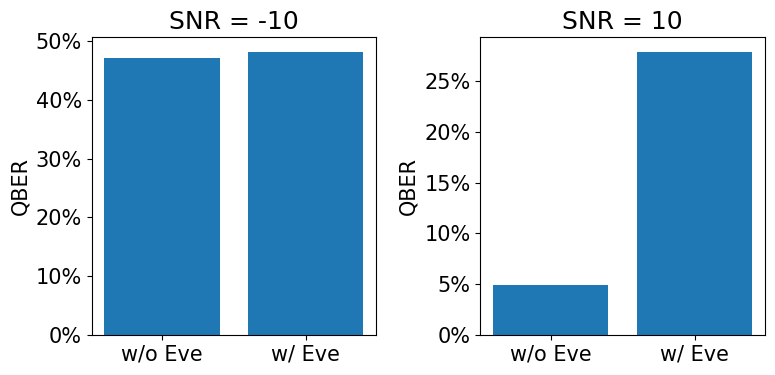

In [5]:
# Plotting results with increased spacing between bars for both SNR values
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot for SNR = -10
labels = ['w/o Eve', 'w/ Eve']
qber_values_neg10 = [qber_no_eve_neg10, qber_with_eve_neg10]
positions = [0, 1]
axs[0].bar(positions, qber_values_neg10, width=0.8)
axs[0].set_xticks(positions)
axs[0].set_xticklabels(labels)
axs[0].set_ylabel('QBER')
axs[0].set_title('SNR = -10')
# Convert y-axis to percentage
axs[0].set_yticklabels([f'{y:.0%}' for y in axs[0].get_yticks()])

# Plot for SNR = 10
qber_values_pos10 = [qber_no_eve_pos10, qber_with_eve_pos10]
axs[1].bar(positions, qber_values_pos10, width=0.8)
axs[1].set_xticks(positions)
axs[1].set_xticklabels(labels)
axs[1].set_ylabel('QBER')
axs[1].set_title('SNR = 10')
# Convert y-axis to percentage
axs[1].set_yticklabels([f'{y:.0%}' for y in axs[1].get_yticks()])

# Set the font size to be larger (2 times the default)
plt.rcParams.update({'font.size': 15})

plt.tight_layout()
plt.show()

# Experiment 1

SNR-QBER

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def run_experiment(snr_values, loss_values, num_bits=10000, num_trials=10):
    results = {}
    for snr in snr_values:
        for loss in loss_values:
            qber_list = []
            for _ in range(num_trials):
                alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss)
                qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
                qber_list.append(qber)
            results[(snr, loss)] = np.mean(qber_list)
    return results

# Sample SNR and Loss values
snr_values = [0, 5, 10, 15, 20]  # in dB
loss_values = [10, 20, 30, 40, 50]  # in dB

# Run the experiment
results_loss = run_experiment(snr_values, loss_values)




In [32]:
import matplotlib.ticker as mtick

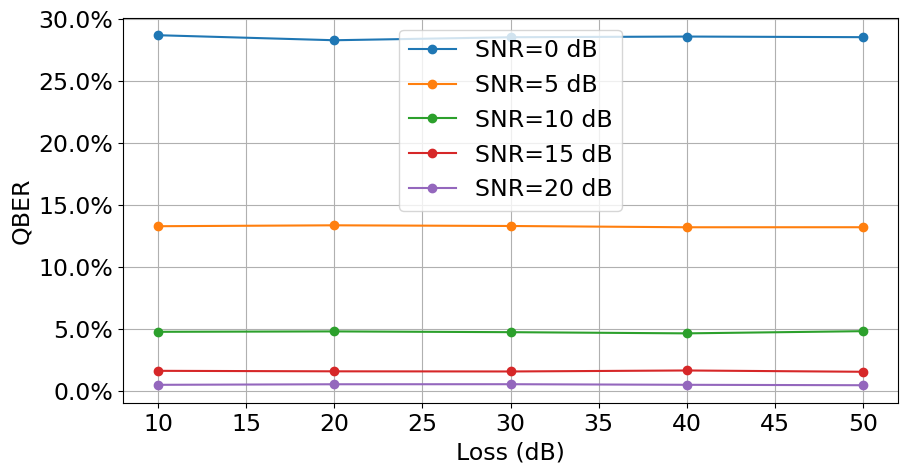

In [34]:
# Plotting the results
plt.figure(figsize=(10, 5))

# QBER Plot
for snr in snr_values:
    qber_values = [results_loss[(snr, loss)] for loss in loss_values]
    
    plt.plot(loss_values, qber_values, marker='o', label=f'SNR={snr} dB')
#plt.title('QBER vs. Loss for different SNR')
plt.xlabel('Loss (dB)')
plt.ylabel('QBER')
plt.grid(True)
plt.legend()
# Convert y-axis to percentage using FuncFormatter
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


plt.show()


In [36]:
def run_snr_experiment(snr_values, fixed_loss, num_bits=10000, num_trials=10):
    qber_no_eve_results = []
    qber_with_eve_results = []
    
    for snr in snr_values:
        qber_no_eve = []
        qber_with_eve = []
        for _ in range(num_trials):
            alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, fixed_loss, with_eve=False)
            qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
            qber_no_eve.append(qber)

            alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, fixed_loss, with_eve=True)
            qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
            qber_with_eve.append(qber)
        qber_no_eve_results.append(np.mean(qber_no_eve))
        qber_with_eve_results.append(np.mean(qber_with_eve))                        
    return qber_no_eve_results, qber_with_eve_results

# Sample SNR values
snr_values = np.linspace(-40, 40, num=17)  # From 0 dB to 20 dB, 11 points

# Fixed loss
fixed_loss = 30  # in dB

# Run the SNR experiment
qber_no_eve, qber_with_eve = run_snr_experiment(snr_values, fixed_loss)



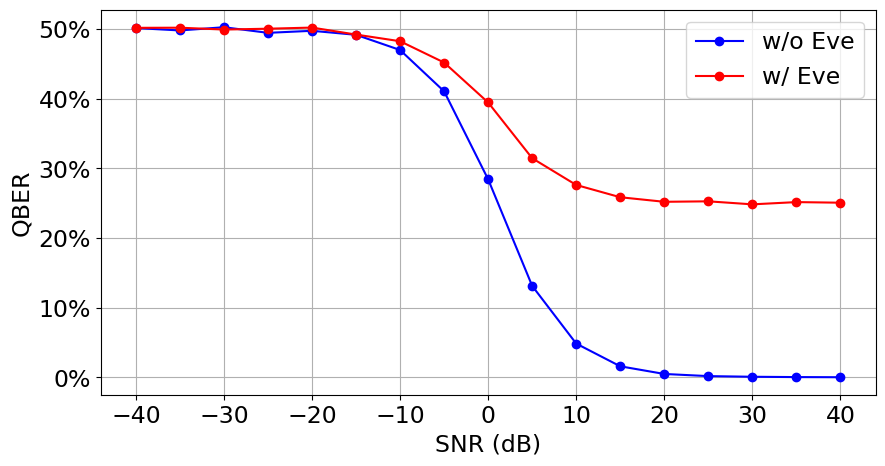

In [37]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(snr_values, qber_no_eve, marker='o', linestyle='-', color='b', label = "w/o Eve")
plt.plot(snr_values, qber_with_eve, marker='o', linestyle='-', color='r', label = "w/ Eve")
#plt.title('QBER vs. SNR with Fixed Loss of 30 dB')
plt.xlabel('SNR (dB)')
plt.ylabel('QBER')
plt.grid(True)
plt.legend()
# Convert y-axis to percentage using FuncFormatter
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.rcParams.update({'font.size': 15})


plt.show()

# Experiment

Base & Eve

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_communication(num_bits, snr, loss, fixed_base=None, with_eve=False):
    """Simulate quantum communication with optional fixed bases and eavesdropping."""
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits) if fixed_base is None else np.array([fixed_base] * num_bits)
    bob_bases = np.random.choice(bases, num_bits)  if fixed_base is None else np.array([fixed_base] * num_bits)
    eve_bases = np.random.choice(bases, num_bits)  if fixed_base is None else np.array([fixed_base] * num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and  alice_bases[i] ==  eve_bases[i] and fixed_base == None:
            qubit = eavesdrop(qubit)
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def run_basis_eve_experiment(num_bits, num_trials, snr, loss):
    results = {
        'Random base w/o Eve': [],
        'Random base w/ Eve': [],
        'Fixed base w/o Eve': [],
        'Fixed base w/ Eve': []
    }
    
    for _ in range(num_trials):
        # Random bases
        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        results['Random base w/o Eve'].append(qber)

        # Random bases with Eve
        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        results['Random base w/ Eve'].append(qber)
        
        # Fixed Z bases
        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, fixed_base='X')
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        results['Fixed base w/o Eve'].append(qber)

        # Fixed Z bases with Eve
        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, fixed_base='Z', with_eve=True)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        results['Fixed base w/ Eve'].append(qber)
    
    return {key: np.mean(value) for key, value in results.items()}

# Parameters
num_bits = 10000
num_trials = 10
snr = 10  # SNR in dB
loss = 20  # Loss in dB

# Run the experiment
results = run_basis_eve_experiment(num_bits, num_trials, snr, loss)



QBER for Random base w/o Eve: 4.85%
QBER for Random base w/ Eve: 27.59%
QBER for Fixed base w/o Eve: 4.73%
QBER for Fixed base w/ Eve: 4.82%


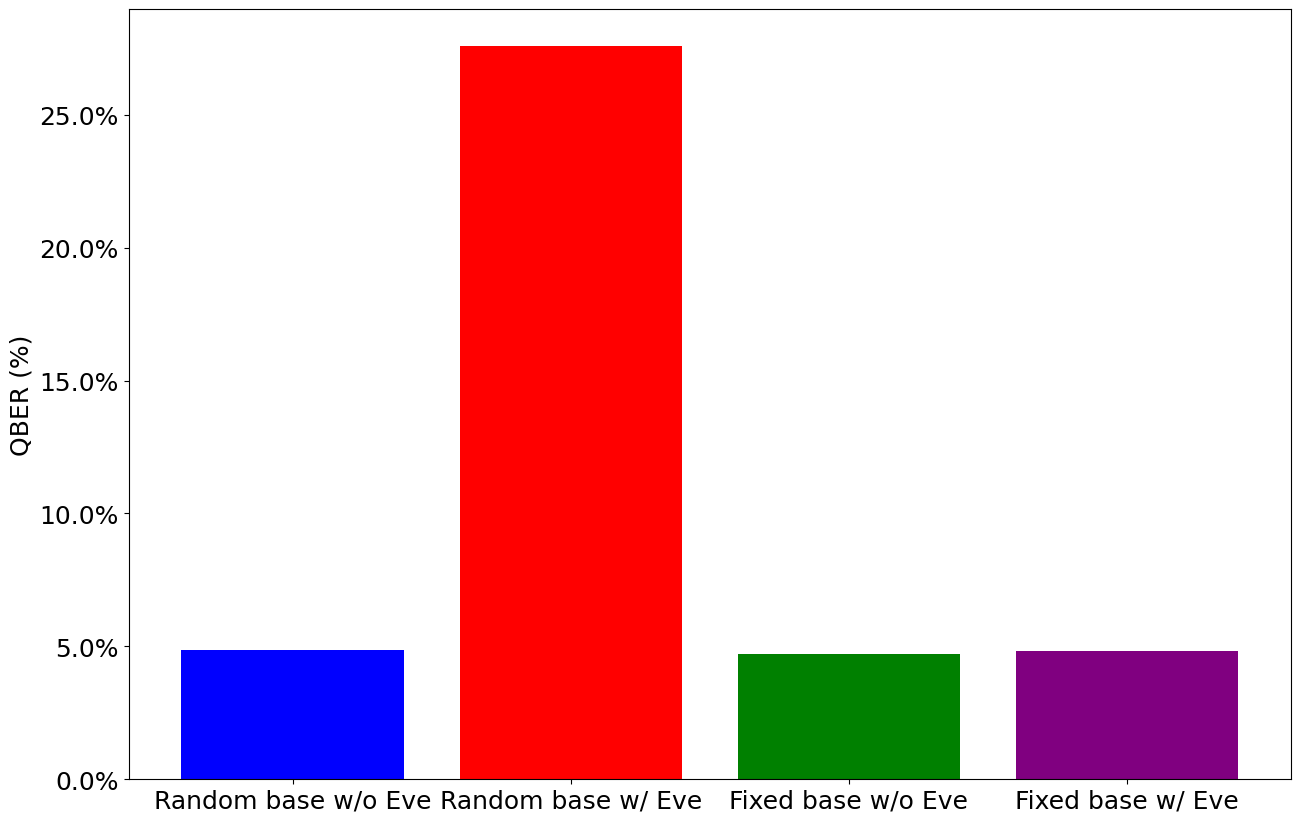

In [25]:
# Output results
for key, qber in results.items():
    print(f"QBER for {key}: {qber * 100:.2f}%")

# Plotting results
labels = ['Random base w/o Eve', 'Random base w/ Eve', 'Fixed base w/o Eve', 'Fixed base w/ Eve']
qber_values = [results[key] for key in labels]
plt.figure(figsize=(15, 10))
plt.bar(labels, qber_values, width = 0.8, color=['blue', 'red', 'green', 'purple'])
plt.ylabel('QBER (%)')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.rcParams.update({'font.size': 17})

#plt.title('QBER for Different Basis Strategies with and without Eve')
plt.show()


# Experiment 3
Attack Rate

In [18]:


def simulate_communication(num_bits, snr, loss, with_eve=False, eve_attack_rate=1.0):
    """Simulate quantum communication with optional eavesdropping by Eve at a specified attack rate."""
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)
    eve_bases = np.random.choice(bases, num_bits)

    
    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and eve_bases[i]==alice_bases[i] and np.random.rand() < eve_attack_rate:
            qubit = eavesdrop(qubit)
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates):
    results = {}
    for rate in eve_attack_rates:
        qber_with_eve = []
        for _ in range(num_trials):
            alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True, eve_attack_rate=rate)
            qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
            qber_with_eve.append(qber)
        results[rate] = np.mean(qber_with_eve)
    return results

# Parameters
num_bits = 10000
num_trials = 10
snr = 10  # Higher SNR means lower noise
loss = 20  # Lower loss means less attenuation
eve_attack_rates = [0, 0.25, 0.5, 0.75, 1.0]  # Attack rates: 10%, 50%, 100%

results_attack_rate = run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates)



QBER with Eve attacking 0% of qubits: 4.74%
QBER with Eve attacking 25% of qubits: 10.47%
QBER with Eve attacking 50% of qubits: 15.98%
QBER with Eve attacking 75% of qubits: 21.50%
QBER with Eve attacking 100% of qubits: 27.27%


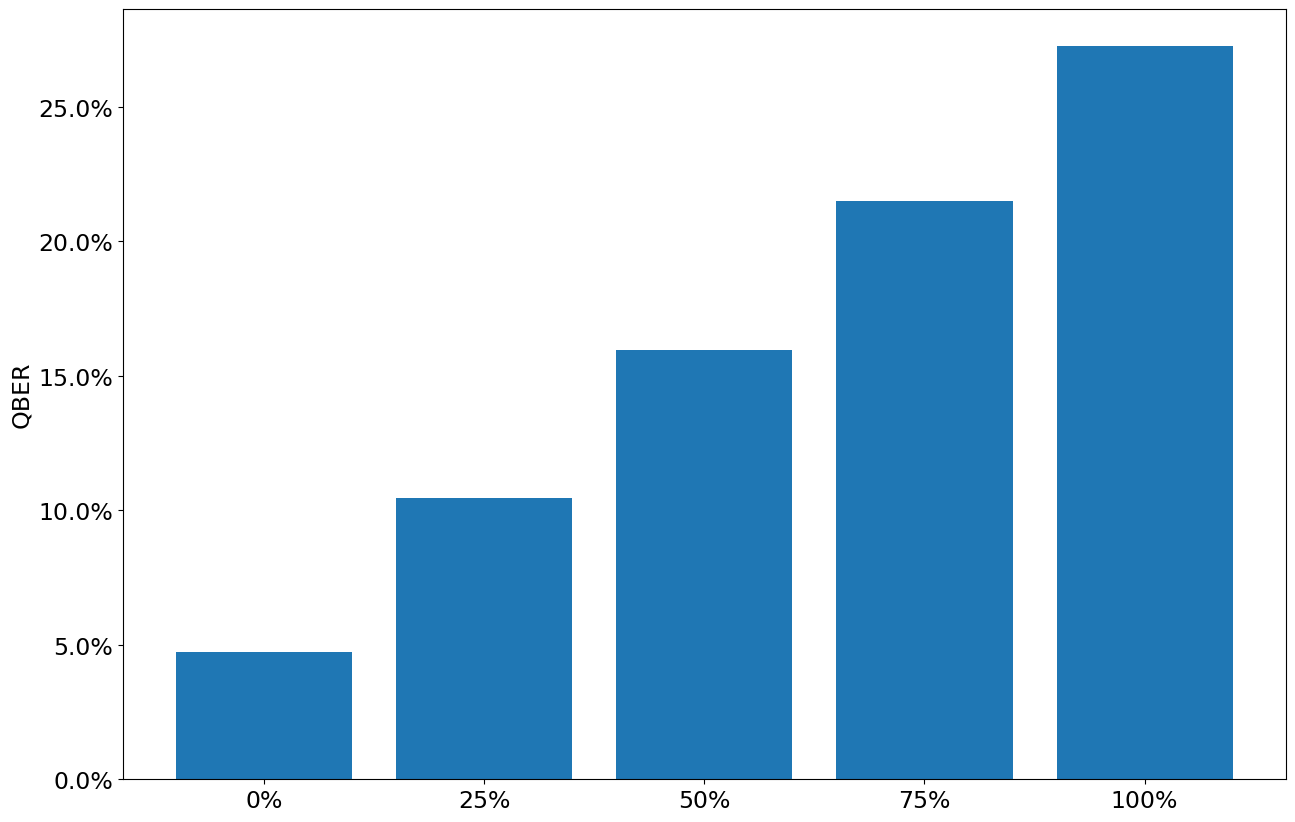

In [26]:
# Output results
for rate, qber in results_attack_rate.items():
    print(f'QBER with Eve attacking {rate*100:.0f}% of qubits: {qber * 100:.2f}%')

# Plotting results
labels = [f'{rate*100:.0f}%' for rate in eve_attack_rates]
qber_values = list(results_attack_rate.values())
plt.figure(figsize=(15, 10))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.rcParams.update({'font.size': 17})

plt.bar(labels, qber_values)
plt.ylabel('QBER')
#plt.title('Quantum Bit Error Rate with Different Eve Attack Rates')
plt.show()


In [76]:
# Exper 4iment

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_communication_with_error_correction(num_bits, snr, loss, with_eve=False):
    """Simulate quantum communication and apply error correction and privacy amplification."""
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve:
            qubit = eavesdrop(qubit)
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    # Error correction and privacy amplification
    corrected_key, final_key = error_correction_and_privacy_amplification(alice_bases, bob_bases, alice_results, bob_results)
    return np.mean(corrected_key), np.mean(final_key)

def error_correction_and_privacy_amplification(alice_bases, bob_bases, alice_results, bob_results):
    """A simple error correction and privacy amplification method."""
    # Find matching bases
    matching_bases_indices = np.where(alice_bases == bob_bases)[0]
    alice_key = np.array(alice_results)[matching_bases_indices]
    bob_key = np.array(bob_results)[matching_bases_indices]
    
    # Error correction (assume some simple parity check)
    error_indices = np.where(alice_key != bob_key)[0]
    for idx in error_indices:
        bob_key[idx] = alice_key[idx]  # Simple correction: Bob copies Alice's bit

    # Privacy amplification (shorten the key by half to remove any potential Eve information)
    final_key_length = len(bob_key) // 2
    final_key = bob_key[:final_key_length]

    return bob_key, final_key

def run_error_correction_experiment(num_bits, num_trials, snr, loss, with_eve=False):
    corrected_keys = []
    final_keys = []
    for _ in range(num_trials):
        corrected_key, final_key = simulate_communication_with_error_correction(num_bits, snr, loss, with_eve)
        corrected_keys.append(corrected_key)
        final_keys.append(final_key)
    
    return np.mean(corrected_keys), np.mean(final_keys)

# Parameters
num_bits = 1000
num_trials = 10
snr = 10  # SNR in dB
loss = 20  # Loss in dB

# Run the experiment
corrected_key_rate, final_key_rate = run_error_correction_experiment(num_bits, num_trials, snr, loss, with_eve=True)

# Output results
print(f"Corrected Key Rate: {corrected_key_rate * 100:.2f}%")
print(f"Final Key Rate after Privacy Amplification: {final_key_rate * 100:.2f}%")


Corrected Key Rate: 50.71%
Final Key Rate after Privacy Amplification: 50.67%


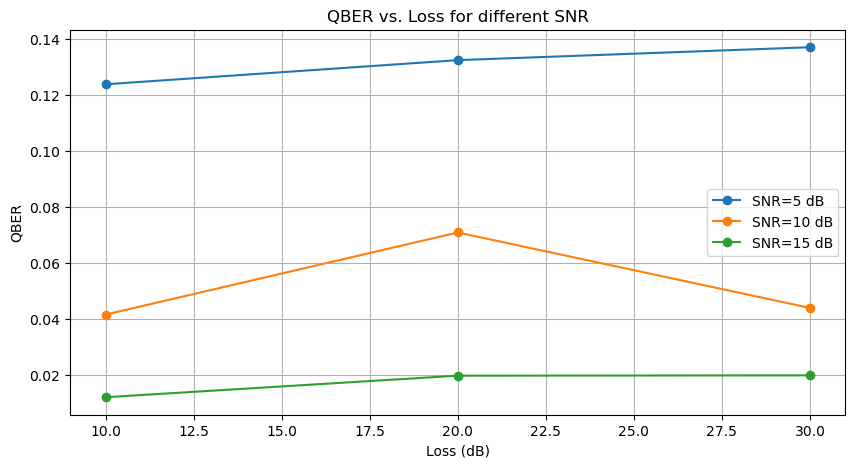

In [83]:
def run_experiment(snr_values, loss_values, num_bits=1000, num_trials=1):
    results = {}
    for snr in snr_values:
        for loss in loss_values:
            qber_list = []
            for _ in range(num_trials):
                alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss)
                qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
                qber_list.append(qber)
            results[(snr, loss)] = np.mean(qber_list)
    return results

# Sample SNR and Loss values
snr_values = [5, 10, 15]  # in dB
loss_values = [10, 20, 30]  # in dB

# Run the experiment
results = run_experiment(snr_values, loss_values)

# Plotting the results
plt.figure(figsize=(10, 5))

# QBER Plot
for snr in snr_values:
    qber_values = [results[(snr, loss)] for loss in loss_values]
    plt.plot(loss_values, qber_values, marker='o', label=f'SNR={snr} dB')
plt.title('QBER vs. Loss for different SNR')
plt.xlabel('Loss (dB)')
plt.ylabel('QBER')
plt.grid(True)
plt.legend()

plt.show()


In [78]:
qber_results

{10: 0.04560370707956486,
 20: 0.05160003044383332,
 30: 0.043695196535039914,
 40: 0.050851697305798436,
 50: 0.04486762884282121}

In [79]:
loss_levels

[10, 20, 30, 40, 50]